In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Data', train=False, download=True, transform=transform)

class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

c:\Users\dearm\.conda\envs\mypytorchenv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


100.0%


Extracting ../Data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../Data\FashionMNIST\raw



100.0%


Extracting ../Data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../Data\FashionMNIST\raw



100.0%


Extracting ../Data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../Data\FashionMNIST\raw



100.0%

Extracting ../Data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../Data\FashionMNIST\raw



In [2]:
# create data loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Label:  [8 7 8 0 0 4 2 0 5 1]
Class:  Bag Sneaker Bag T-shirt T-shirt Coat Sweater T-shirt Sandal Trouser


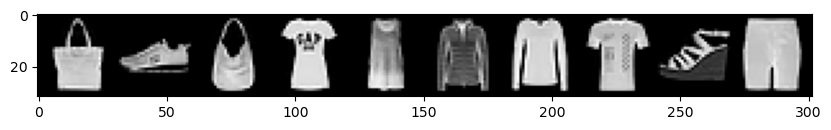

In [3]:
# examine a batch of images
for images, labels in train_loader:
    break

print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=10)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

In [4]:
# define a CNN model, set a random seed, instantiate the model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 100)
        self.fc2 = nn.Linear(100,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)
    
torch.manual_seed(101)
model = ConvolutionalNetwork()

In [5]:
# number of trainable parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    54
     6
   864
    16
 40000
   100
  1000
    10
______
 42050


In [6]:
# define loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# train the model!
epochs = 5

train_losses = []

for i in range(epochs):

    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())

    print(f'Epoch {i} is complete, with loss {loss.item():10.8f}')

Epoch 0 is complete, with loss 0.52479279
Epoch 1 is complete, with loss 0.04064159
Epoch 2 is complete, with loss 0.40872175
Epoch 3 is complete, with loss 0.15733257
Epoch 4 is complete, with loss 0.34585303


In [8]:
# evaluate the model
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8831/10000 =  88.310%
